In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import igraph as ig
import math
import numpy as np

import datetime
import dateutil.parser
import pytz

In [2]:
df = pd.read_csv("./datasets/data.csv")
numStudents = df["id_aluno"].nunique()

In [3]:
grouped = df.groupby('id_aluno').agg({
    'id_questao':list, 'acerto_resposta':list, 'tempo_resposta': list}).reset_index()

In [4]:
def compare_integers_power_law(integer1, integer2, max_value):
    log_absolute_difference = abs(math.log(integer1 + 1) - math.log(integer2 + 1))
    log_max_value = math.log(max_value + 1)
    metric = 1 - log_absolute_difference / log_max_value
    return max(0, metric)  # Garante que a métrica retorna entre 0 e 1

In [5]:
def compare_integers_linear(integer1, integer2, max_value):
    absolute_difference = abs(integer1 -integer2)
    metric = 1 - absolute_difference / max_value
    return max(0, metric)  # Garante que a métrica retorna entre 0 e 1

In [6]:
def createGraph(n_vertices, edges, weights):
    g = ig.Graph(n_vertices, edges)
    g["title"] = "Similaridade entre Alunos"
    g.es["weights"] = weights
    return g

In [8]:
def plotGraphWithClusterColors(g, clustering, name):
    fig, ax = plt.subplots(figsize=(5,5))
    clusterToColor = { 0: "#000000", 1: "#303030", 2: "#606060", 3: "#909090",
                       4: "#C0C0C0", 5: "#E0E0E0", 6: "#FFFFFF", 7: "red",}
    ig.plot(
        g,
        target=ax,
        vertex_size=0.1,
        vertex_color=[clusterToColor[a] for a in clustering.membership],
        vertex_label=g.vs.indices,
        vertex_label_size=4.0
    )
    plt.show()
    fig.savefig(name + '.png')
    fig.savefig(name + '.jpg')
    fig.savefig(name + '.pdf')
    g.save(name + ".gml")
    g = ig.load(name + ".gml")

In [9]:
def calculateSimilarities(df, compare_function, weightThreshold, aux=False):
    grouped = df.groupby('id_aluno').agg({
        'id_questao':list, 'acerto_resposta':list, 'tempo_resposta': list}).reset_index()
    edges = []
    weights = []
    maxTime = df['tempo_resposta'].max()
    # Para cada par único de alunos
    for a0 in grouped.index:
        for a1 in grouped[a0+1:].index:
            peso = 0
            # Para cada par entre as respostas entre um e outro.
            for t0 in range(0,len(grouped["id_questao"][a0])):
                for t1 in range(0,len(grouped["id_questao"][a1])):
                    # Se mesma questão:
                        #   Soma ao peso da aresta entre alunos dependendo da similaridade da questão
                    if (grouped["id_questao"][a0][t0] == grouped["id_questao"][a1][t1]):
                        diffTempo = compare_function(
                            grouped["tempo_resposta"][a0][t0],
                            grouped["tempo_resposta"][a1][t1],
                            maxTime
                        )
                        diffAcerto = grouped["acerto_resposta"][a0][t0] == grouped["acerto_resposta"][a1][t1]
                        peso += diffTempo*diffAcerto
            # if aux : 
            #     print(peso > weightThreshold, peso, weightThreshold)
            if (peso > weightThreshold):
                edges.append((a0,a1))
                weights.append(peso)
    return edges, weights


In [10]:
edges, weights = calculateSimilarities(df, compare_integers_power_law, 0, True)
normalizedWeights = (np.array(weights)-np.min(np.array(weights)))/(np.max(np.array(weights))-np.min(np.array(weights))) 

edgesLi, weightsLi = calculateSimilarities(df, compare_integers_linear, 0)
normalizedLiWeights = (np.array(weightsLi)-np.min(np.array(weightsLi)))/(np.max(np.array(weightsLi))-np.min(np.array(weightsLi))) 

# edgesTh, weightsTh = calculateSimilarities(df, compare_integers_power_law, 0.753258, True)
# normalizedWeightsTh = (np.array(weightsTh)-np.min(np.array(weightsTh)))/(np.max(np.array(weightsTh))-np.min(np.array(weightsTh))) 

# edgesLiTh, weightsLiTh = calculateSimilarities(df, compare_integers_linear, 0.961575)
# normalizedLiWeightsTh = (np.array(weightsLiTh)-np.min(np.array(weightsLiTh)))/(np.max(np.array(weightsLiTh))-np.min(np.array(weightsLiTh))) 

In [11]:
g = createGraph(numStudents, edges, weights)
gNormalized = createGraph(numStudents, edges, normalizedWeights)

# gThreshHold = createGraph(numStudents, edgesTh, weightsTh)
# gThreshHoldNormalized = createGraph(numStudents, edgesTh, normalizedWeightsTh)

gLinear = createGraph(numStudents, edgesLi, weightsLi)
gLinearNormalized = createGraph(numStudents, edgesLi, normalizedLiWeights)

# gThreshHoldLinear = createGraph(numStudents, edgesLiTh, weightsLiTh)
# gThreshHoldLinearNormalized = createGraph(numStudents, edgesLiTh, weightsLiTh)

In [15]:
res = {"OG":{}, "Linear": {}}

In [107]:
# print("Modularidades InfoMap:")

# res["OG"]["IM"] = g.community_infomap(edge_weights='weights', trials=3)
# res["OGNorm"]["IM"] = gNormalized.community_infomap(edge_weights='weights', trials=3)
# res["OG-25%"]["IM"] = gThreshHold.community_infomap(edge_weights='weights', trials=3)
# res["OG-25%Norm"]["IM"] = gThreshHoldNormalized.community_infomap(edge_weights='weights', trials=3)
# res["Linear"]["IM"] = gLinear.community_infomap(edge_weights='weights', trials=3)
# res["LinearNorm"]["IM"] = gLinearNormalized.community_infomap(edge_weights='weights', trials=3)
# res["Linear-25%"]["IM"] = gThreshHoldLinear.community_infomap(edge_weights='weights', trials=3)
# res["Linear-25%Norm"]["IM"] = gThreshHoldLinearNormalized.community_infomap(edge_weights='weights', trials=3)

# for key in res:
#     print("Modularidade: " + key + " " + str(res[key]["IM"].modularity))
# print("Modularidades Label Propagation")

# res["OG"]["LP"] = g.community_label_propagation(weights='weights',initial=[+(i < 100) for i in range(0,numStudents)])
# res["OGNorm"]["LP"] = gNormalized.community_label_propagation(weights='weights',initial=[+(i < 100) for i in range(0,numStudents)])
# res["OG-25%"]["LP"] = gThreshHold.community_label_propagation(weights='weights',initial=[+(i < 100) for i in range(0,numStudents)])
# res["OG-25%Norm"]["LP"] = gThreshHoldNormalized.community_label_propagation(weights='weights',initial=[+(i < 100) for i in range(0,numStudents)])
# res["Linear"]["LP"] = gLinear.community_label_propagation(weights='weights',initial=[+(i < 100) for i in range(0,numStudents)])
# res["LinearNorm"]["LP"] = gLinearNormalized.community_label_propagation(weights='weights',initial=[+(i < 100) for i in range(0,numStudents)])
# res["Linear-25%"]["LP"] = gThreshHoldLinear.community_label_propagation(weights='weights',initial=[+(i < 100) for i in range(0,numStudents)])
# res["Linear-25%Norm"]["LP"] = gThreshHoldLinearNormalized.community_label_propagation(weights='weights',initial=[+(i < 100) for i in range(0,numStudents)])

# for key in res:
#     print("Modularidade: " + key + " " + str(res[key]["LP"].modularity))

In [16]:
print("Modularidades Fast and Greedy")

res["OG"]["FG"] = g.community_fastgreedy(weights='weights').as_clustering()
# res["OGNorm"]["FG"] = gNormalized.community_fastgreedy(weights='weights').as_clustering()
# res["OG-25%"]["FG"] = gThreshHold.community_fastgreedy(weights='weights').as_clustering()
# res["OG-25%Norm"]["FG"] = gThreshHoldNormalized.community_fastgreedy(weights='weights').as_clustering()
res["Linear"]["FG"] = gLinear.community_fastgreedy(weights='weights').as_clustering()
# res["LinearNorm"]["FG"] = gLinearNormalized.community_fastgreedy(weights='weights').as_clustering()
# res["Linear-25%"]["FG"] = gThreshHoldLinear.community_fastgreedy(weights='weights').as_clustering()
# res["Linear-25%Norm"]["FG"] = gThreshHoldLinearNormalized.community_fastgreedy(weights='weights').as_clustering()

for key in res:
    print("Modularidade: " + key + " " + str(res[key]["FG"].modularity))

Modularidades Fast and Greedy
Modularidade: OG 0.2408638281375374
Modularidade: Linear 0.22095829736593636


In [17]:
print("Modularidades Leading Eigenvector")

res["OG"]["LE"] = g.community_leading_eigenvector(weights='weights')
# res["OGNorm"]["LE"] = gNormalized.community_leading_eigenvector(weights='weights')
# res["OG-25%"]["LE"] = gThreshHold.community_leading_eigenvector(weights='weights')
# res["OG-25%Norm"]["LE"] = gThreshHoldNormalized.community_leading_eigenvector(weights='weights')
res["Linear"]["LE"] = gLinear.community_leading_eigenvector(weights='weights')
# res["LinearNorm"]["LE"] = gLinearNormalized.community_leading_eigenvector(weights='weights')
# res["Linear-25%"]["LE"] = gThreshHoldLinear.community_leading_eigenvector(weights='weights')
# res["Linear-25%Norm"]["LE"] = gThreshHoldLinearNormalized.community_leading_eigenvector(weights='weights')

for key in res:
    print("Modularidade: " + key + " " + str(res[key]["LE"].modularity))

Modularidades Leading Eigenvector
Modularidade: OG 0.25786155650192405
Modularidade: Linear 0.2531635627896662


In [18]:
print("Modularidades Leiden")

res["OG"]["L"] = g.community_leiden(weights='weights', beta=1, n_iterations=10)
# res["OGNorm"]["L"] = gNormalized.community_leiden(weights='weights', beta=1, n_iterations=10)
# res["OG-25%"]["L"] = gThreshHold.community_leiden(weights='weights', beta=1, n_iterations=10)
# res["OG-25%Norm"]["L"] = gThreshHoldNormalized.community_leiden(weights='weights', beta=1, n_iterations=10)
res["Linear"]["L"] = gLinear.community_leiden(weights='weights', beta=1, n_iterations=10)
# res["LinearNorm"]["L"] = gLinearNormalized.community_leiden(weights='weights', beta=1, n_iterations=10)
# res["Linear-25%"]["L"] = gThreshHoldLinear.community_leiden(weights='weights', beta=1, n_iterations=10)
# res["Linear-25%Norm"]["L"] = gThreshHoldLinearNormalized.community_leiden(weights='weights', beta=1, n_iterations=10)

for key in res:
    print("Modularidade: " + key + " " + str(res[key]["L"].modularity))

Modularidades Leiden
Modularidade: OG 0.09427911623423887
Modularidade: Linear 0.17098436959100793


In [19]:
print("Modularidades Multilevel")

res["OG"]["ML"] = g.community_multilevel(weights='weights')
# res["OGNorm"]["ML"] = gNormalized.community_multilevel(weights='weights')
# res["OG-25%"]["ML"] = gThreshHold.community_multilevel(weights='weights')
# res["OG-25%Norm"]["ML"] = gThreshHoldNormalized.community_multilevel(weights='weights')
res["Linear"]["ML"] = gLinear.community_multilevel(weights='weights')
# res["LinearNorm"]["ML"] = gLinearNormalized.community_multilevel(weights='weights')
# res["Linear-25%"]["ML"] = gThreshHoldLinear.community_multilevel(weights='weights')
# res["Linear-25%Norm"]["ML"] = gThreshHoldLinearNormalized.community_multilevel(weights='weights')

for key in res:
    print("Modularidade: " + key + " " + str(res[key]["ML"].modularity))

Modularidades Multilevel
Modularidade: OG 0.2747278381735722
Modularidade: Linear 0.26080695246803703


In [20]:
print("Modularidades WalkTrap")

res["OG"]["WT"] = g.community_walktrap(weights='weights').as_clustering()
# res["OGNorm"]["WT"] = gNormalized.community_walktrap(weights='weights').as_clustering()
# res["OG-25%"]["WT"] = gThreshHold.community_walktrap(weights='weights').as_clustering()
# res["OG-25%Norm"]["WT"] = gThreshHoldNormalized.community_walktrap(weights='weights').as_clustering()
res["Linear"]["WT"] = gLinear.community_walktrap(weights='weights').as_clustering()
# res["LinearNorm"]["WT"] = gLinearNormalized.community_walktrap(weights='weights').as_clustering()
# res["Linear-25%"]["WT"] = gThreshHoldLinear.community_walktrap(weights='weights').as_clustering()
# res["Linear-25%Norm"]["WT"] = gThreshHoldLinearNormalized.community_walktrap(weights='weights').as_clustering()

for key in res:
    print("Modularidade: " + key + " " + str(res[key]["WT"].modularity))

Modularidades WalkTrap
Modularidade: OG 0.18703751580057593
Modularidade: Linear 0.19590929085114894


FG


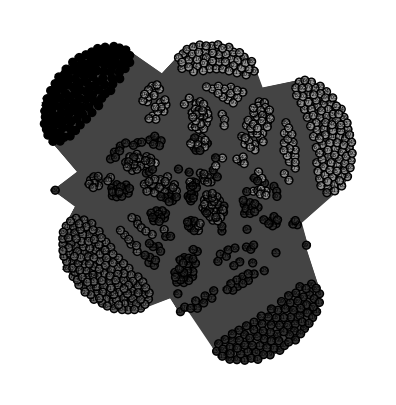

LE


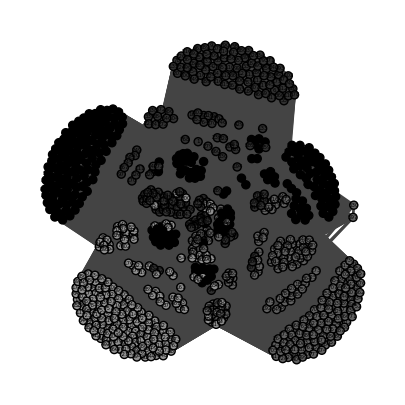

L


KeyError: 8

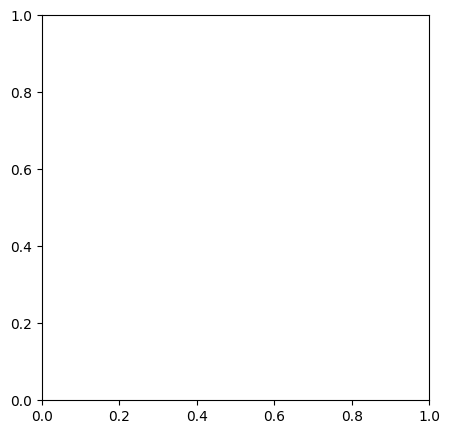

In [21]:
for key in res:
    for alg in res[key]:
        print(alg)
        plotGraphWithClusterColors(g, res[key][alg], "all")

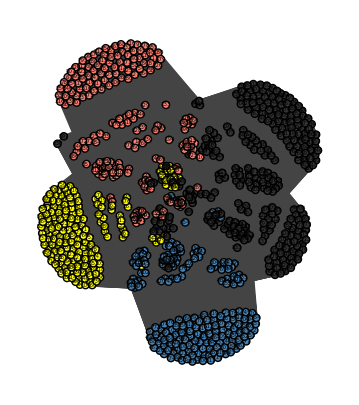

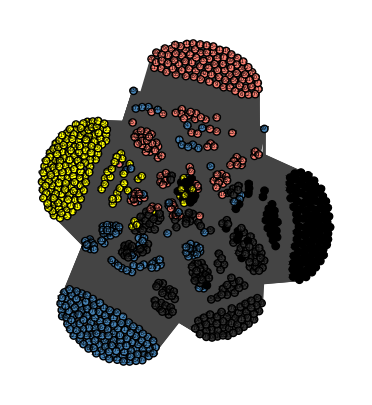

In [106]:
plotGraphWithClusterColors(g, res["OG"]["ML"], "OG ML")
plotGraphWithClusterColors(g, res["OG-25%Norm"]["ML"], "OG-25%Norm ML")

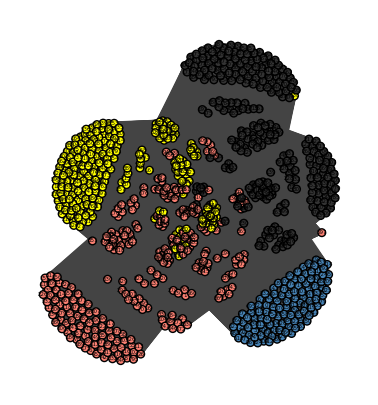

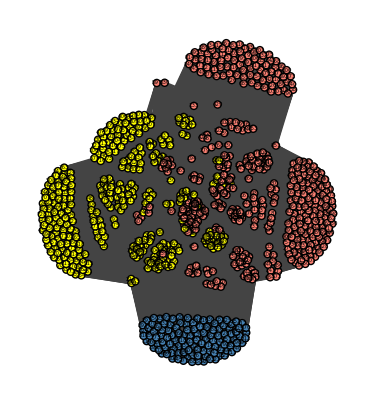

In [108]:
plotGraphWithClusterColors(g, res["OG"]["FG"], "OG FG")
plotGraphWithClusterColors(g, res["Linear"]["FG"], "OG-25%Norm FG")